## HeartXtract Demo Notebook to characterize heart structure categories and patient descriptors from MIMIC-III notes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
import numpy as np
import os

from google.colab import auth
from google.cloud import bigquery
from google.colab import files

In [ ]:
auth.authenticate_user()

In [ ]:
PROJECT_ID = 'your_project_id'
PATH_TO_SAVE_UNIQUE_HEART_STRUCT_SENT = 'path_to_save_unique_heart_struct_sent'
PATH_TO_LOAD_HEART_ANNOT = 'path_to_load_heart_annot/*.txt'
PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT = 'path_to_save_heart_annot_per_patient.csv'
PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS = 'path_to_save_heart_annot_per_patient_w_other_descriptors.csv'
PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS_NO_TEXT = 'path_to_save_heart_annot_per_patient_w_other_\
                                                                    descriptors_no_text.csv' #optional"
PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS_TEXT_DROP_NO_FINDINGS ='path_to_save_heart_annot_per_patient_\
                                                                                  w_other_descriptors_drop_no_findings.csv'
PATH_TO_CREDENTIALED_DATA = 'path_to_credentialed_data.csv'

In [ ]:
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id = project_id, configuration = {'query':{'useLegacySql': False}})

In [ ]:
# Load the heart notes from BigQuery (alternatively read in the notes.csv)
echo_notes = run_query('''
    SELECT ne.text
    FROM  `physionet-data.mimiciii_notes.noteevents` as ne
    WHERE  ne.category = 'Echo'
    --LIMIT 5
      ''')

In [ ]:
# Extract unique sentences per heart structure from the heart notes.
from collections import defaultdict
import re
def extract_heart_annotations(notes):
  notes_series= echo_notes['text']
  d = defaultdict(list)
  list_look_for = ['LEFT ATRIUM', 'LEFT VENTRICLE','MITRAL VALVE', 'RIGHT ATRIUM/INTERATRIAL SEPTUM',
                   'RIGHT VENTRICLE','AORTIC VALVE','PULMONIC VALVE/PULMONARY ARTERY']
  for row in notes_series:
    sentence_section_processed = row.split('\n\n')
    for each_line in sentence_section_processed:
      each_line=re.sub('\n',' ',each_line)
      two_info=each_line.split(':')
      if two_info[0] in list_look_for:
        value_split_period=two_info[1].split(". ")
        value_split_period=[i.rstrip('.').strip() for i in value_split_period]
        d[two_info[0]] += value_split_period
  for i in list_look_for:
    d[i] = list(set(d[i]))
  return d

In [ ]:
# Write the unique cardiovascular structure information to separate files (no need to rerun if already
# saved the file).
import re
import datetime
import pytz
dictionary_output = extract_heart_annotations(echo_notes)
heart_struct_to_abbrev = {'LEFT ATRIUM' : 'LA',
                  'RIGHT ATRIUM/INTERATRIAL SEPTUM' : 'RA',
                  'LEFT VENTRICLE' : 'LV',
                  'RIGHT VENTRICLE' : 'RV',
                  'MITRAL VALVE' : 'MV',
                  'AORTIC VALVE' : 'AV',
                  'TRICUSPID VALVE' : 'TV'
                  }
for name in heart_struct_to_abbrev.keys():
  short_file_name = heart_struct_to_abbrev[name]
  date_append = re.sub(r"[:|\s|\.]","-",str(datetime.datetime.now(pytz.timezone('US/Eastern'))))
  file = open(PATH_TO_SAVE_UNIQUE_HEART_STRUCT_SENT + f'{short_file_name}_{date_append}.txt', 'w')
  for heart_domain in dictionary_output.keys():
    if name == heart_domain:
      file.write('\n'.join(dictionary_output[heart_domain]))
  file.close()

In [ ]:
# Load the echo notes per patient.
echo_notes_per_patient = run_query('''
  SELECT ne.subject_id, ne.hadm_id, ne.row_id, ne.category, ne.text, ne.chartdate
  FROM  `physionet-data.mimiciii_notes.noteevents` as ne
  WHERE   ne.category = 'Echo'
  --LIMIT 5
''')

In [ ]:
# Read in the heart annotations.
import collections
import re
import glob
import collections
heart_annotations = collections.defaultdict(lambda:collections.defaultdict(lambda: collections.defaultdict(dict)))

for filename in glob.iglob(PATH_TO_LOAD_HEART_ANNOT,
                           recursive = True):
    heart_struct_charact=filename.split('/')[-1].split('.')[0]
    heart_struct = filename.split('/')[-1].split('.')[0].split('_')[0]
    dictionary_value_sent = collections.defaultdict(list)
    with open(filename) as file:
        for line in file:
          match=re.search('\s*====(\-[0-9]|[0-9])',line)
          if match:
           value= float(match.group(1))
          else:
            dictionary_value_sent[value].append(line.rstrip('\n'))
    heart_annotations[heart_struct][heart_struct_charact] = dictionary_value_sent
    heart_annotations

In [ ]:
# Extract unique sentences for each heart structure per patient.
import collections
import re
import glob
short_abbrev = {'LEFT ATRIUM' : 'LA',
                  'RIGHT ATRIUM/INTERATRIAL SEPTUM' : 'RA',
                  'LEFT VENTRICLE' : 'LV',
                  'RIGHT VENTRICLE' : 'RV',
                  'MITRAL VALVE' : 'MV',
                  'AORTIC VALVE' : 'AV',
                  'TRICUSPID VALVE' : 'TV'
               }
patient_sentences = []
for row in echo_notes_per_patient.text:
  d = collections.defaultdict(list)
  list_look_for = ['LEFT ATRIUM', 'LEFT VENTRICLE','MITRAL VALVE', 'RIGHT ATRIUM/INTERATRIAL SEPTUM',
                   'RIGHT VENTRICLE','AORTIC VALVE', 'TRICUSPID VALVE']
  sentence_section_processed = row.split('\n\n')
  for each_line in sentence_section_processed:
    each_line = re.sub('\n',' ',each_line)
    two_info = each_line.split(':')
    if two_info[0] in list_look_for:
      value_split_period=two_info[1].split(". ")
      value_remove_space = []
      for i in value_split_period:
        value_remove_space.append(i.strip().strip('.'))
      d[two_info[0]] += (value_remove_space)
  for i in list_look_for:
    d[i] = list(set(d[i]))
  patient_sentences.append(d)

In [ ]:
# Extract the heart categories for each patient based on the heart annotations.
for row,dictionary in enumerate(patient_sentences):
  filename_severity_dict = {}
  for section_name,text_list in dictionary.items():
    value_short_key=short_abbrev[section_name]
    for first_level_key in heart_annotations:
        if value_short_key == first_level_key:
            for section_sentence in text_list:
                section_sentence = section_sentence.strip()
                for filename, dictionary_severity_sent in heart_annotations[first_level_key].items():
                    for severity, sent_list in dictionary_severity_sent.items():
                        if section_sentence in sent_list:
                            if filename == 'TV_stenosis' or filename == 'TV_regurgitation' \
                            or filename == 'TV_pulm_htn' or filename == 'LV_systolic'or filename == 'LV_cavity' \
                            or filename == 'LV_diastolic' or filename == 'LV_wall'or filename == 'LA_cavity'  \
                            or filename == 'RV_systolic' or filename == 'RV_cavity' or filename == 'AV_regurgitation' \
                            or filename == 'AV_stenosis' or filename == 'MV_regurgitation' or filename == 'MV_stenosis'\
                            or filename == 'RV_pressure_overload' or filename == 'RA_pressure' :
                                if severity !=-3 and severity !=0 and severity != -2 and severity != -1:
                                    if not filename in filename_severity_dict:
                                        filename_severity_dict[filename] = severity
                                    filename_severity_dict[filename] = max(filename_severity_dict[filename],
                                                                           severity)
                                else:
                                    if not filename in filename_severity_dict:
                                        filename_severity_dict[filename] = severity
                                    elif filename_severity_dict[filename] != severity:
                                        filename_severity_dict[filename] = -50
                            if filename == 'RV_volume_overload' or filename =='RV_wall'or filename =='RA_dilated':
                                if severity !=-3 :
                                    if not filename in filename_severity_dict:
                                        filename_severity_dict[filename] = severity
                                else:
                                    if not filename in filename_severity_dict:
                                        filename_severity_dict[filename] = severity
                                    elif filename_severity_dict[filename] != severity:
                                        filename_severity_dict[filename] = -50

  for filename in filename_severity_dict.keys():
      echo_notes_per_patient.loc[echo_notes_per_patient.index[row],filename] = filename_severity_dict[filename]
      pd.set_option('display.max_colwidth',1000000)
      pd.set_option('display.width',1000000)

In [ ]:
# Save the heart annotations per patient note.
data = echo_notes_per_patient.to_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT, index = False)

In [ ]:
# Read the heart annotations per patient note.
data = pd.read_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT)
data.columns

Index(['subject_id', 'hadm_id', 'row_id', 'category', 'text', 'chartdate', 'RA_dilated', 'LV_cavity', 'LV_systolic', 'LV_wall', 'RV_cavity', 'RV_systolic', 'RV_wall', 'AV_stenosis', 'AV_regurgitation', 'MV_regurgitation', 'TV_regurgitation', 'TV_pulm_htn', 'TV_stenosis', 'LA_cavity', 'RA_pressure', 'MV_stenosis'], dtype='object')

In [ ]:
# Add other descriptors found in notes for each patient.
import re
from datetime import datetime

for index, row in data.iterrows():
  match1 = re.search('(Height: \(in\)) (\d+)',row['text'])
  match2 = re.search('(Weight \(lb\):) (\d+)',row['text'])
  match3 = re.search('(HR \(bpm\):) (\d+)',row['text'])
  match4 = re.search('(Status:) (.+)',row['text'])
  match5 = re.search('(BP \(mm Hg\):) (\d+)/(\d+)',row['text'])
  match6 = re.search('(Date/Time:) \[\*\*(.+)\*\*\] at (.*)',row['text'])
  match7 = re.search('(Technical Quality:) (.*)',row['text'])
  match8 = re.search('(Contrast:) (.*)',row['text'])
  match9 = re.search('(Test:) (.*)',row['text'])
  match10 = re.search('(Doppler:) (.*)',row['text'])
  match11 = re.search('(BSA \(m2\):) ([+-]?[0-9]+\.?[0-9]*) (m2)',row['text'])

  if match1:
    data.loc[index, "height (in)"] = int(match1.group(2))
  if match2:
    data.loc[index, "weight (lb)"] = int(match2.group(2))
  if match3:
    data.loc[index, "heart rate (bpm)"] = int(match3.group(2))
  if match4:
    data.loc[index, "status"] = match4.group(2)
  if match5:
    data.loc[index, "sbp (mm Hg)"] = match5.group(2)
    data.loc[index, "dbp (mm Hg)"] = match5.group(3)
  if match6:
    data.loc[index, "date_time"] = datetime.strptime(match6.group(2)  + " " + match6.group(3), '%Y-%m-%d %H:%M')
  if match7:
     data.loc[index, "technical_quality"] = match7.group(2)
  if match8:
     data.loc[index, "contrast"] = match8.group(2)
  if match9:
     data.loc[index, "test"] = match9.group(2)
  if match10:
     data.loc[index, "doppler"] = match10.group(2)
  if match11:
    data.loc[index, "BSA (m^2)"] = match11.group(2)

In [ ]:
data.columns

Index(['subject_id', 'hadm_id', 'row_id', 'category', 'text', 'chartdate', 'RA_dilated', 'LV_cavity', 'LV_systolic', 'LV_wall', 'RV_cavity', 'RV_systolic', 'RV_wall', 'AV_stenosis', 'AV_regurgitation', 'MV_regurgitation', 'TV_regurgitation', 'TV_pulm_htn', 'TV_stenosis', 'LA_cavity', 'RA_pressure', 'MV_stenosis', 'heart rate (bpm)', 'status', 'sbp (mm Hg)', 'dbp (mm Hg)', 'date_time', 'technical_quality', 'contrast', 'test', 'doppler', 'height (in)', 'weight (lb)', 'BSA (m^2)'], dtype='object')

In [ ]:
# Save other descriptions for each patient.
data.to_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS, index = False)

In [ ]:
# Read in the data with other descriptos and drop text columns (optional).
data_w_other_descriptors = pd.read_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS)
data_w_other_descriptors_no_text = data_w_other_descriptors.drop(columns = ['text'])
data_w_other_descriptors_no_text.to_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS_NO_TEXT, index = False)

In [ ]:
# Remove patients with no findings in the text.
pattern = "INTERPRETATION:\n\nFindings:\n\n\n\n"

matched_rows = []
for index, row in data_w_other_descriptors.iterrows():
    if pattern in row['text']:
        matched_rows.append(row['row_id'])

num_matched_rows=len(matched_rows)
total_rows=len(data_w_other_descriptors)

print(f"Found {num_matched_rows} rows out of {total_rows} that follow the pattern.")
data_w_other_descriptors_drop_no_findings = data_w_other_descriptors[~data_w_other_descriptors['row_id'].isin(matched_rows)]


In [ ]:
data_w_other_descriptors_drop_no_findings.to_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS_TEXT_DROP_NO_FINDINGS)

In [ ]:
data_w_other_descriptors_drop_no_findings = pd.read_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_\
                                                        W_OTHER_DESCRIPTORS_TEXT_DROP_NO_FINDINGS)
data_w_other_descriptors_drop_no_findings.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'row_id', 'category', 'text', 'chartdate', 'RA_dilated', 'LV_cavity', 'LV_systolic', 'LV_wall', 'RV_cavity', 'RV_systolic', 'RV_wall', 'AV_stenosis', 'AV_regurgitation', 'MV_regurgitation', 'TV_regurgitation', 'TV_pulm_htn', 'TV_stenosis', 'LA_cavity', 'RA_pressure', 'MV_stenosis', 'heart rate (bpm)', 'status', 'sbp (mm Hg)', 'dbp (mm Hg)', 'date_time', 'technical_quality', 'contrast', 'test', 'doppler', 'height (in)', 'weight (lb)', 'BSA (m^2)'], dtype='object')

In [ ]:
# Check the frequency of categories per echo categorization.
header_list = ['LA_cavity', 'RA_dilated', 'LV_systolic', 'LV_cavity', 'LV_wall', 'RV_cavity',
               'RV_systolic',  'AV_stenosis', 'MV_stenosis', 'TV_regurgitation', 'TV_stenosis',
               'TV_pulm_htn', 'AV_regurgitation','MV_regurgitation', 'RA_pressure', 'LV_diastolic',
               'RV_volume_overload', 'RV_wall', 'RV_pressure_overload']

In [ ]:
credentialed_data = pd.read_csv(PATH_TO_CREDENTIALED_DATA)
#data_w_other_descriptors_drop_no_findings #45794-1352=44442 # Found 1352 rows out of 45794 that follow the pattern.

In [ ]:
credentialed_data.columns

Index(['subject_id', 'hadm_id', 'row_id', 'category', 'text', 'chartdate', 'LA_cavity', 'RA_dilated', 'LV_systolic', 'LV_cavity', 'LV_wall', 'RV_cavity', 'RV_systolic', 'AV_stenosis', 'MV_stenosis', 'TV_regurgitation', 'TV_stenosis', 'TV_pulm_htn', 'AV_regurgitation', 'MV_regurgitation', 'RA_pressure', 'LV_diastolic', 'RV_volume_overload', 'RV_wall', 'RV_pressure_overload', 'height (in)', 'weight (lb)', 'heart rate (bpm)', 'status', 'sbp (mm Hg)', 'dbp (mm Hg)', 'date_time', 'technical_quality', 'contrast', 'test', 'doppler', 'BSA (m^2)'], dtype='object')

In [ ]:
for column in header_list:
  counts = pd.DataFrame(credentialed_data[column].value_counts(dropna = False))
  counts = counts.rename_axis(counts.columns[0], axis = "columns")
  counts.rename(columns = {column: "frequency"}, inplace = True)
  display(counts)

LA_cavity,frequency
NaN,23269
0.0,8097
1.0,6697
2.0,3723
-2.0,3341
-50.0,596
-3.0,63
3.0,8


RA_dilated,frequency
NaN,18275
0.0,14268
1.0,13251


LV_systolic,frequency
0.0,23089
NaN,10363
3.0,3901
1.0,2984
2.0,2503
-1.0,1824
-2.0,767
-3.0,228
-50.0,135


LV_cavity,frequency
0.0,30587
NaN,9861
2.0,2041
1.0,1444
-1.0,933
3.0,497
-2.0,247
-3.0,137
-50.0,47


LV_wall,frequency
0.0,19317
NaN,12060
1.0,11782
2.0,1803
3.0,398
-2.0,229
-3.0,141
-50.0,64


RV_cavity,frequency
0.0,30117
NaN,7058
1.0,3016
-2.0,2064
2.0,1787
-3.0,1289
-50.0,294
-1.0,169


RV_systolic,frequency
0.0,30431
NaN,6682
-2.0,2465
1.0,2123
-3.0,1460
2.0,1329
3.0,974
-50.0,330


AV_stenosis,frequency
0.0,24912
NaN,15583
1.0,2262
3.0,1874
2.0,822
-2.0,195
-3.0,122
-50.0,24


MV_stenosis,frequency
NaN,28772
0.0,16355
1.0,457
2.0,88
-3.0,70
3.0,46
-50.0,6


TV_regurgitation,frequency
NaN,27054
0.0,16666
-3.0,1204
-2.0,487
-50.0,350
1.0,17
2.0,11
3.0,5


TV_stenosis,frequency
0.0,25547
NaN,18686
-3.0,1512
-50.0,36
1.0,10
2.0,3


TV_pulm_htn,frequency
NaN,18926
1.0,8380
2.0,6052
0.0,5740
-3.0,5359
3.0,939
-50.0,398


AV_regurgitation,frequency
0.0,19520
1.0,12555
NaN,12132
2.0,756
3.0,471
-50.0,176
-2.0,175
-3.0,9


MV_regurgitation,frequency
0.0,14626
NaN,13179
1.0,11143
2.0,3281
3.0,1967
-50.0,1056
-2.0,542


RA_pressure,frequency
NaN,42426
1.0,1319
0.0,1251
2.0,418
-3.0,378
-50.0,2


LV_diastolic,frequency
NaN,41768
-2.0,1685
0.0,1179
1.0,399
-3.0,384
2.0,206
3.0,125
-50.0,48


RV_volume_overload,frequency
NaN,43169
-3.0,1494
1.0,1128
-50.0,3


RV_wall,frequency
NaN,40905
0.0,2372
-3.0,1511
1.0,993
-50.0,13


RV_pressure_overload,frequency
NaN,42961
-3.0,1472
1.0,1357
-50.0,4


In [ ]:
# Verify if the annotation was assigned correctly based on the given text for a patient.
data_check=pd.read_csv(PATH_TO_SAVE_HEART_ANNOT_PER_PATIENT_W_OTHER_DESCRIPTORS_TEXT_DROP_NO_FINDINGS)
df=data_check[['text']][data_check['RA_dilated'] == 1]
df.head(1)
# nRIGHT ATRIUM/INTERATRIAL SEPTUM: Mildly dilated RA.

,text
0,"PATIENT/TEST INFORMATION:\nIndication: Left ventricular function.\nBP (mm Hg): 105/43\nHR (bpm): 118\nStatus: Outpatient\nDate/Time: [**2111-4-22**] at 15:08\nTest: TTE (Complete)\nDoppler: Full doppler and color doppler\nContrast: None\nTechnical Quality: Suboptimal\n\n\nINTERPRETATION:\n\nFindings:\n\nRIGHT ATRIUM/INTERATRIAL SEPTUM: Mildly dilated RA.\n\nLEFT VENTRICLE: Moderate symmetric LVH. Small LV cavity. Suboptimal technical\nquality, a focal LV wall motion abnormality cannot be fully excluded.\nHyperdynamic LVEF.\n\nRIGHT VENTRICLE: Normal RV wall thickness. Dilated RV cavity. RV function\ndepressed.\n\nAORTIC VALVE: ?# aortic valve leaflets. Mildly thickened aortic valve\nleaflets. No AS. Mild (1+) AR.\n\nMITRAL VALVE: Mildly thickened mitral valve leaflets. No MVP. Moderate mitral\nannular calcification. Mild thickening of mitral valve chordae. Calcified tips\nof papillary muscles. MR present but cannot be quantified.\n\nTRICUSPID VALVE: TR present - cannot be quantified.\n\nPERICARDIUM: Trivial/physiologic pericardial effusion.\n\nGENERAL COMMENTS: Suboptimal image quality - poor echo windows. Suboptimal\nimage quality - poor parasternal views. Suboptimal image quality - poor apical\nviews. Suboptimal image quality as the patient was difficult to position.\n\nConclusions:\nThere is moderate symmetric left ventricular hypertrophy. The left ventricular\ncavity is unusually small. Due to suboptimal technical quality, a focal wall\nmotion abnormality cannot be fully excluded. Left ventricular systolic\nfunction appears hyperdynamic (EF>75%). The right ventricular cavity is\ndilated. Right ventricular systolic function appears depressed. The number of\naortic valve leaflets cannot be determined. The aortic valve leaflets are\nmildly thickened. There is no aortic valve stenosis. Mild (1+) aortic\nregurgitation is seen. The mitral valve leaflets are mildly thickened. There\nis no mitral valve prolapse. Mitral regurgitation is present but cannot be\nquantified. Tricuspid regurgitation is present but cannot be quantified. There\nis a trivial/physiologic pericardial effusion.\n\n\n"


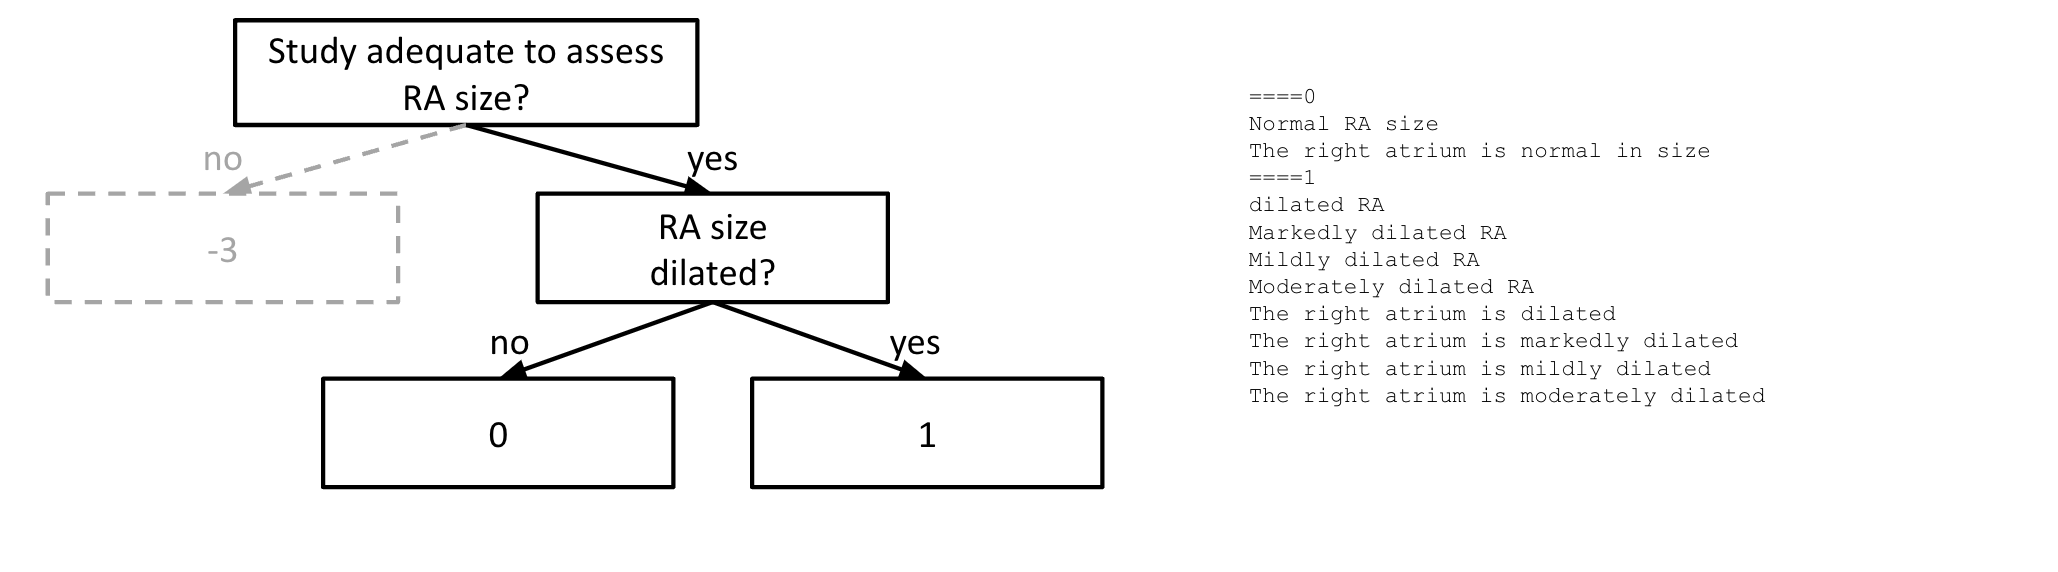